# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [354]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [355]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [356]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [357]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [358]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [359]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [360]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [361]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [362]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [363]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [364]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [365]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [366]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [367]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [368]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [369]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [370]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [371]:
# sent_1500 = decontracted(sent_1500)
# print(sent_1500)
# print("="*50)

In [372]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [373]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
# sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
# print(sent_1500)

In [374]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [375]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:23<00:00, 1939.62it/s]


In [376]:
final['Text'] = preprocessed_reviews
X = final['Text'].values

# [4] Featurization

## [4.1] BAG OF WORDS

In [377]:
#BoW
count_vect = CountVectorizer(min_df=10, max_features=5000) #in scikit-learn
count_vect.fit(X)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'acai', 'accept', 'acceptable', 'accepted']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 5000)
the number of unique words  5000


## [4.3] TF-IDF

In [378]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.4] Word2Vec

In [379]:
# Train your own Word2Vec model using your own text corpus
list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())

In [380]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=2)

In [381]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [382]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 46071/46071 [01:57<00:00, 392.36it/s]


46071
50


#### [4.4.1.2] TFIDF weighted W2v

In [383]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [384]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 46071/46071 [16:41<00:00, 46.02it/s]


## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [385]:
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from matplotlib.pyplot import figure

In [386]:
# Elbow method to find best K (No. of clusters)
def Find_OptimizedCluster(vector):
    clusters = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    inertia = []
    for i in range(5,51,5):
        model = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=1, n_jobs=-1, algorithm='auto')
        model.fit(vector)
        inertia.append(model.inertia_)

    plt.plot(clusters, inertia, label ='Distance')
    plt.legend()
    plt.xlabel("K Clusters: Hyperparameter")
    plt.ylabel("Inertia")
    plt.title("Elbow Plot")
    plt.show()

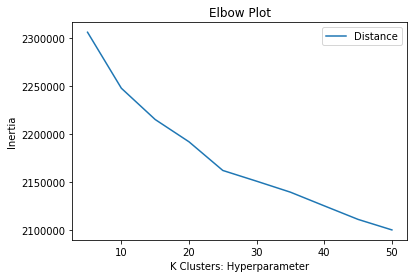

In [387]:
Find_OptimizedCluster(final_counts)

OBSERVATION :- From above we can see that there is inflection at K = 25 . Befor it inertia/distance was decreasing faster as compared to the distance decreasing after it. Hence, the best value of K is 25.

In [388]:
# Function applies KMeans on all vectorizer and return an array of closest cluster each sample in X belongs to
def KMeans_Clusters(no_Of_Clusters, vector):
    model = KMeans(n_clusters=no_Of_Clusters, init='k-means++', n_init=10, max_iter=300, random_state=1, n_jobs=-1, 
                   algorithm='auto')
    model.fit(vector)
    pred_cluster = model.predict(vector) # Predict the closest cluster each sample in X belongs to
    return pred_cluster

In [389]:
predicted_cluster_bow = KMeans_Clusters(25, final_counts)

In [390]:
# Getting number of reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(predicted_cluster_bow.shape[0]):
    if predicted_cluster_bow[i] == 1:
        cluster1.append(X[i])
    elif predicted_cluster_bow[i] == 2:
        cluster2.append(X[i])

# Number of reviews in different clusters
print("Number of reviews in Cluster-1: ",len(cluster1))
print("Reviews in Cluster-1: ",cluster1[:2])
print("\nNumber of reviews in Cluster-2: ",len(cluster2))
print("Reviews in Cluster-2: ",cluster2[:2])

Number of reviews in Cluster-1:  795
Reviews in Cluster-1:  ['love sunflower seeds chocolate cherries imagine delight found chocolate cherry sunflower seeds available amazon packet arrived tore open downed entire contents eager mouth expecting explosion chocolate cherry sunflowery sapidity instead got mouthful hard shells crunched tough outer hulls wondering inventiveness manufacturers somehow injected chocolate cherry flavors hard unopened shells macerated hull softer kernel splintery mash found chocolate cherry flavors somehow gone missing wife came home mentioned ripped chocolate cherry sunflower seeds lacked chocolate cherry flavors fact barely edible wife picked empty packet looked moment hit head dining room chair idiot said seeds planting clobbered antique oak coat tree not know ever married continued always stupid embarrassing things no matter hard hit never learn whacked coffee table emphasis maybe gotten bad batch seeds think order next time manufacturers better not forget ch

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [391]:
list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())

# Function returns the reviews belong to particular cluster
def Get_ReviewsForCluster(predicted_cluster, clusterNumber):
    reviews = []
    for i in range(len(predicted_cluster)):
        if predicted_cluster[i] == clusterNumber:
            reviews.append(list_of_sentance[i])
    return reviews

In [392]:
# Return the reviews belong to cluster 1
reviews = Get_ReviewsForCluster(predicted_cluster_bow, 1)

In [393]:
# Create WordCloud for words in reviews
def Get_WordCloud(reviews):
    
    words_in_reviews = ' '.join([str(word) for sublist in reviews for word in sublist])
    
    plt.figure(figsize=(6,6))
    word_cloud = WordCloud(max_words=100, background_color="white").generate(words_in_reviews)
    plt.imshow(word_cloud,aspect='auto', interpolation='bilinear')
    plt.axis('off')
    plt.show()

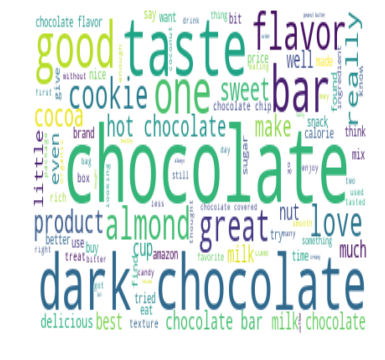

In [394]:
# Word cloud for cluster 1
Get_WordCloud(reviews)

* This cluster contain words related to chinese food (noodle, soup, sauce, pasta)

In [395]:
# Reviews for cluster 2
reviews2 = Get_ReviewsForCluster(predicted_cluster_bow, 2)

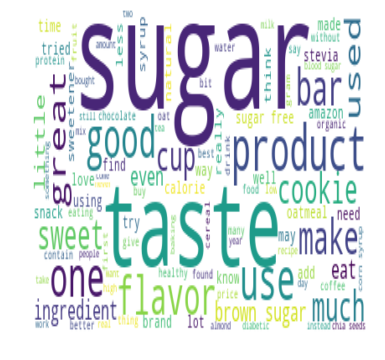

In [396]:
# Wordcloud for cluster 2
Get_WordCloud(reviews2)

In [397]:
# Reviews for cluster 3
reviews3 = Get_ReviewsForCluster(predicted_cluster_bow, 3)

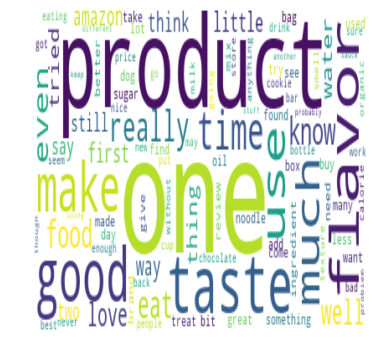

In [398]:
#Word Cloud for cluster 3
Get_WordCloud(reviews3)

### Conclusion
* Applied KMeans clustering on Bag of words and created the word cloud of cluster(1,2,3) to analyse the what kind of word are there in each cluster.
* Most common words in clusters are written in larger size in the image.

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

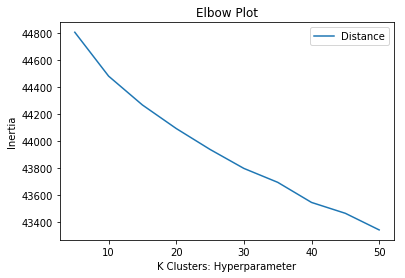

In [399]:
# Find best K for KMeans on TFIDF using Elbow method
Find_OptimizedCluster(final_tf_idf)

In [400]:
predicted_cluster_tfidf = KMeans_Clusters(25, final_tf_idf)

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [401]:
# Reviews for cluster 1
reviews = Get_ReviewsForCluster(predicted_cluster_tfidf, 1)

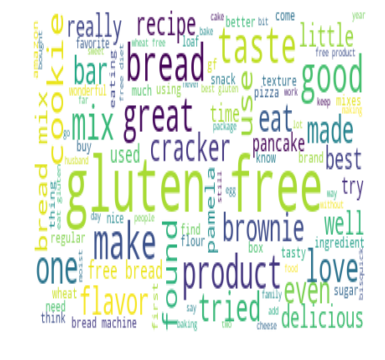

In [402]:
#Word Cloud for cluster 1
Get_WordCloud(reviews)

In [403]:
# Reviews for cluster 2
reviews2 = Get_ReviewsForCluster(predicted_cluster_tfidf, 2)

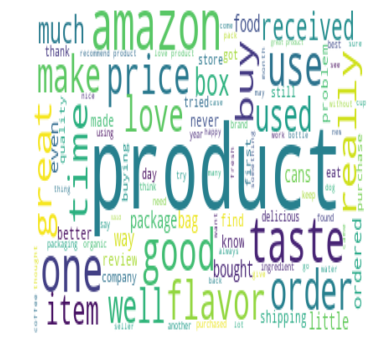

In [404]:
#Word Cloud for cluster 2
Get_WordCloud(reviews2)

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

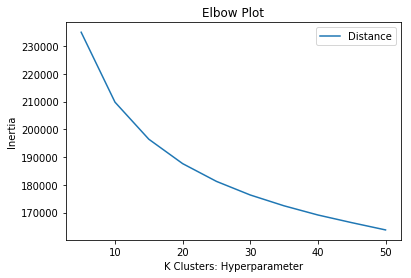

In [405]:
# Find best K for KMeans on AVG W2V using Elbow method
Find_OptimizedCluster(sent_vectors)

In [406]:
predicted_cluster_AvgW2v = KMeans_Clusters(15, sent_vectors)

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [407]:
# Reviews for cluster 1
reviews = Get_ReviewsForCluster(predicted_cluster_AvgW2v, 1)

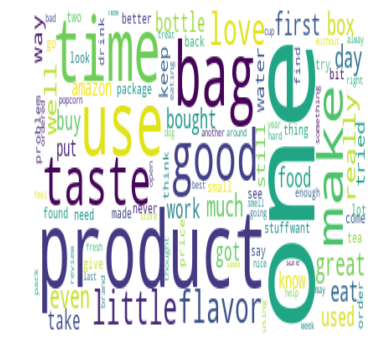

In [408]:
#Word Cloud for cluster 1
Get_WordCloud(reviews)

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

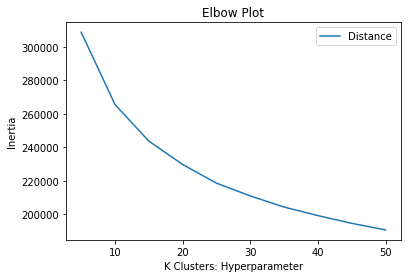

In [409]:
# Find best K for KMeans on TFIDF W2V using Elbow method
Find_OptimizedCluster(tfidf_sent_vectors)

In [410]:
predicted_cluster_tfidf_W2v = KMeans_Clusters(15, tfidf_sent_vectors)

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [411]:
# Reviews for cluster 1
reviews = Get_ReviewsForCluster(predicted_cluster_tfidf_W2v, 1)

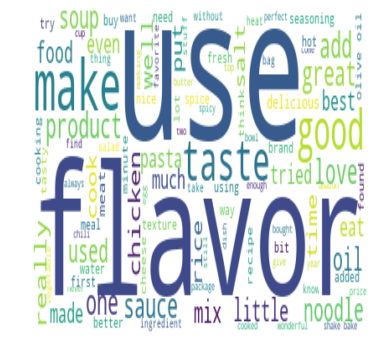

In [412]:
#Word Cloud for cluster 1
Get_WordCloud(reviews)

## [5.2] Agglomerative Clustering

In [413]:
from sklearn.cluster import AgglomerativeClustering

In [414]:
# Selecting only 5000 reviews as Agglomerative is expensive
X = X[:5000]

#### Word2Vec

In [415]:
# Train your own Word2Vec model using your own text corpus 
list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=2)

In [416]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4108
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try']


## Converting text into vectors using Avg W2V, TFIDF-W2V

####  Avg W2v

In [417]:
# average Word2Vec
# compute average word2vec for each review.
def avgw2v(list_of_sentance):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [418]:
sent_vectors = avgw2v(list_of_sentance)
print(len(sent_vectors[0]))
print(len(list_of_sentance))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 655.12it/s]


50
5000


#### TFIDF weighted W2v

In [419]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [420]:
# TF-IDF weighted Word2Vec
def tfidfw2v(list_of_sentance):
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [421]:
tfidf_sent_vectors = tfidfw2v(list_of_sentance)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.59it/s]


### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [422]:
# AgglomerativeClustering using 2 clusters
clustering = AgglomerativeClustering(n_clusters=2)
clustering.fit(sent_vectors)
predicted_cluster_AvgW2v_2 = clustering.fit_predict(sent_vectors)

In [423]:
# AgglomerativeClustering using 5 clusters
clustering = AgglomerativeClustering(n_clusters=5)
clustering.fit(sent_vectors)
predicted_cluster_AvgW2v_5 = clustering.fit_predict(sent_vectors)

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [424]:
# Reviews for cluster 1 for AgglomerativeClustering using 2 clusters
reviews2 = Get_ReviewsForCluster(predicted_cluster_AvgW2v_2, 1)

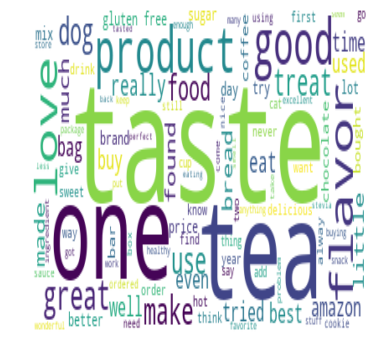

In [425]:
#Word Cloud for cluster 1
Get_WordCloud(reviews2)

In [426]:
# Reviews for cluster 1 for AgglomerativeClustering using 5 clusters
reviews5 = Get_ReviewsForCluster(predicted_cluster_AvgW2v_5, 1)

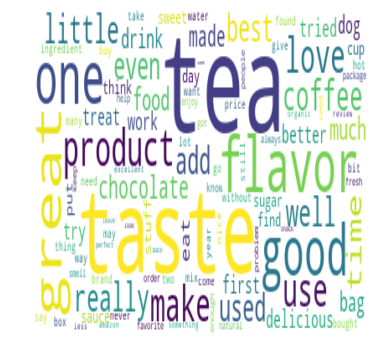

In [427]:
#Word Cloud for cluster 1
Get_WordCloud(reviews5)

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [428]:
# AgglomerativeClustering using 2 clusters on TFIDF W2V
Agg_model = AgglomerativeClustering(n_clusters=2)
Agg_model.fit(tfidf_sent_vectors)
predicted_cluster_tfidfw2v_2 = Agg_model.fit_predict(tfidf_sent_vectors)

In [429]:
# AgglomerativeClustering using 5 clusters on TFIDF W2V
Agg_model = AgglomerativeClustering(n_clusters=2)
Agg_model.fit(tfidf_sent_vectors)
predicted_cluster_tfidfw2v_5 = Agg_model.fit_predict(tfidf_sent_vectors)

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

In [430]:
# Reviews for cluster 1 for AgglomerativeClustering using 2 clusters
reviews2 = Get_ReviewsForCluster(predicted_cluster_tfidfw2v_2, 1)

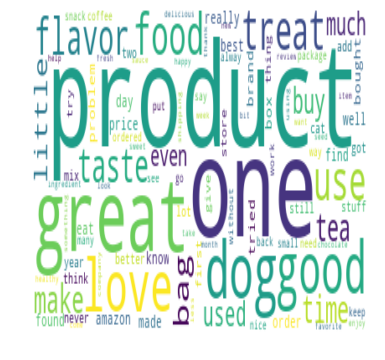

In [431]:
#Word Cloud for cluster 1
Get_WordCloud(reviews2)

In [432]:
# Reviews for cluster 1 for AgglomerativeClustering using 5 clusters
reviews5 = Get_ReviewsForCluster(predicted_cluster_tfidfw2v_5, 1)

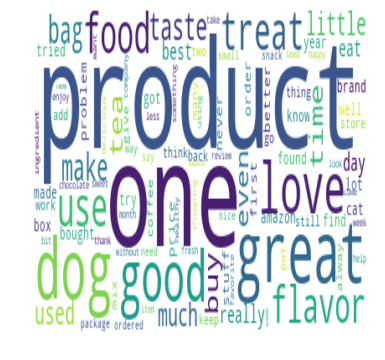

In [433]:
#Word Cloud for cluster 1
Get_WordCloud(reviews5)

## Conclusion

* We have applied AgglomerativeClustering on Avg W2vec and Tfidf W2vec with 5k datapoints.
* We can see the word cloud of cluster formed in the image.
* We can interpret what type of words are there in this cloud.

## [5.3] DBSCAN Clustering

In [434]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [435]:
# DBSCAN on AVG W2V using eps =0.1
dbscan_model = DBSCAN(eps=0.1, min_samples=5, metric='euclidean', n_jobs=-1)
dbscan_model.fit(sent_vectors)
predicted_cluster_bdscan_AvgW2v_1 = dbscan_model.fit_predict(sent_vectors)

In [436]:
# DBSCAN on AVG W2V using eps =0.5
dbscan_model = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', n_jobs=-1)
dbscan_model.fit(sent_vectors)
predicted_cluster_bdscan_AvgW2v_2 = dbscan_model.fit_predict(sent_vectors)

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [437]:
# Reviews for first cluster for DBSCAN using eps 0.1
reviews1 = Get_ReviewsForCluster(predicted_cluster_bdscan_AvgW2v_1, 0)

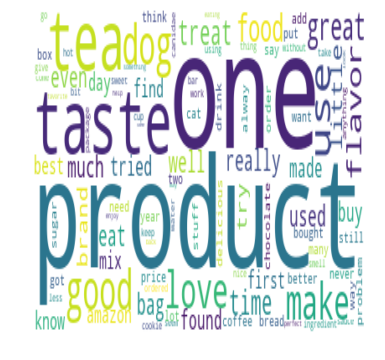

In [438]:
#Word Cloud for cluster 1
Get_WordCloud(reviews1)

In [439]:
# Reviews for first cluster for DBSCAN using eps 0.5
reviews2 = Get_ReviewsForCluster(predicted_cluster_bdscan_AvgW2v_2, 0)

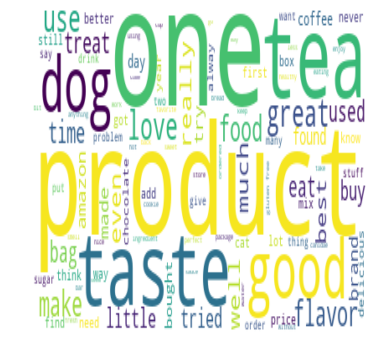

In [440]:
#Word Cloud for cluster 1
Get_WordCloud(reviews2)

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [441]:
# DBSCAN on TFIDF W2V using eps =0.1
dbscan_model = DBSCAN(eps=0.1, min_samples=5, metric='euclidean', n_jobs=-1)
dbscan_model.fit(tfidf_sent_vectors)
predicted_cluster_bdscan_tfidfW2v_1 = dbscan_model.fit_predict(tfidf_sent_vectors)

In [442]:
# DBSCAN on TFIDF W2V using eps =0.5
dbscan_model = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', n_jobs=-1)
dbscan_model.fit(tfidf_sent_vectors)
predicted_cluster_bdscan_tfidfW2v_2 = dbscan_model.fit_predict(tfidf_sent_vectors)

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [443]:
# Reviews for first cluster for DBSCAN using eps 0.1
reviews1 = Get_ReviewsForCluster(predicted_cluster_bdscan_tfidfW2v_1, 0)

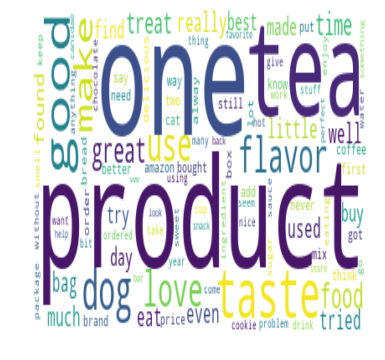

In [444]:
#Word Cloud for first cluster 
Get_WordCloud(reviews1)

In [445]:
# Reviews for first cluster for DBSCAN using eps 0.5
reviews2 = Get_ReviewsForCluster(predicted_cluster_bdscan_tfidfW2v_2, 0)

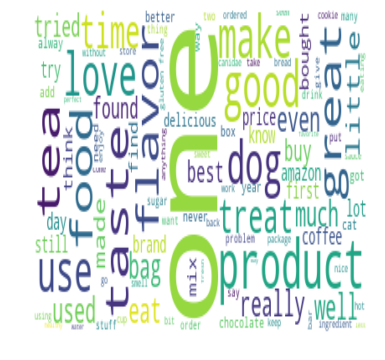

In [446]:
#Word Cloud for first cluster 
Get_WordCloud(reviews2)

# Conclusions

* We have applied DBSCAN on Avg W2vec and Tfidf W2vec with 5k datapoints.
* We can see the word cloud of cluster formed in the image.
* We can interpret what type of words are there in this cloud.

KMeans :

* STEP 1 :- Text Preprocessing
* STEP 2:- Applied vectorizer on text_data and transform it into vectors using 50K datapoints
* STEP 4:- Applied Elbow Method using K-means++ to find optimal value of K (Number of clusters)
* STEP 5:- Draw plot for Inertia VS K-values
* STEP 6:- Optimal value of K then used in K-Means for clustering text_data into K clusters

Repeated from STEP 3 to STEP 6 for each of these four vectorizers : Bag Of Words(BoW), TFIDF, Avg Word2Vec and TFIDF Word2Vec

Agglomerative : 

1) Applied on 5K data point using Avg Word2Vec and TFIDF Word2Vec vectorizer

DBSCAN :

1) Applied on 5K data point using Avg Word2Vec and TFIDF Word2Vec vectorizer